Accuracy (Original Model): 0.7567567567567568
Classification Report (Original Model):
              precision    recall  f1-score   support

         bad       0.76      0.70      0.73       798
        good       0.75      0.81      0.78       904

    accuracy                           0.76      1702
   macro avg       0.76      0.75      0.75      1702
weighted avg       0.76      0.76      0.76      1702



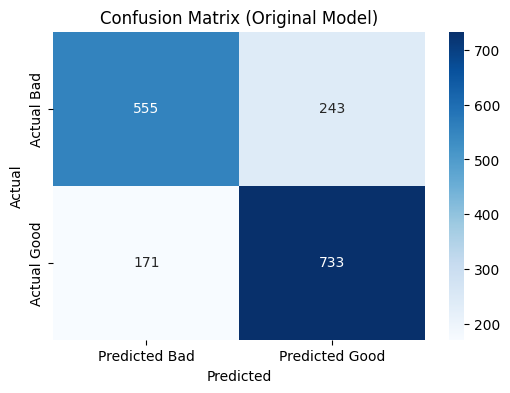

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

# Importing the data
dataset = pd.read_excel('/Users/mustafa/Documents/GitHub/ML_knife_QA/data/chiefs_knife_dataset.xlsx')
index_Ra = dataset.columns.get_loc('Ra')  # Index der Spalte für Rauheit

# Spezifikationsgrenzen
LOWER_SPECIFICATION_LIMIT = 0.125
UPPER_SPECIFICATION_LIMIT = 0.215

# Einteilung in "gut" und "schlecht"
is_between_specification_bounds = (dataset['Ra'] >= LOWER_SPECIFICATION_LIMIT) & (dataset['Ra'] < UPPER_SPECIFICATION_LIMIT)
good_product_range = np.where(is_between_specification_bounds, "good", "bad")
dataset.insert(index_Ra + 1, 'Quality', good_product_range)

# Features und Zielvariable
X = dataset.loc[:, 'Original_Linienanzahl':'DFT_Median_sobel_Bereich'].values
y = dataset['Quality'].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature-Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelltraining mit RandomForestClassifier (Vor Randomized Search)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_scaled, y_train)

# Vorhersagen
y_pred = classifier.predict(X_test_scaled)

# Evaluierung
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy (Original Model): {accuracy}')
print(f'Classification Report (Original Model):\n{report}')

# Confusion Matrix für das Originalmodell
cm_original = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Bad', 'Predicted Good'], yticklabels=['Actual Bad', 'Actual Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Original Model)')
plt.show()

# Hyperparameter-Raster für Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'] # 'auto' durch None ersetzt
}

# Randomized Search für Random Forest Classifier
random_search_classifier = RandomizedSearchCV(estimator=classifier,
                                              param_distributions=param_grid, 
                                              n_iter=100, # Anzahl der zufälligen Kombinationen
                                              cv=5,       # Cross-Validation-Folds
                                              scoring='accuracy', # search for the HP combination with the best accuracy
                                              n_jobs=-1,  # Alle verfügbaren Kerne verwenden
                                              verbose=2,  # Ausführlichkeit
                                              random_state=42)  # Für Reproduzierbarkeit
random_search_classifier.fit(X_train_scaled, y_train)

# Ausgabe der besten Hyperparameter
print(f'Beste Hyperparameter für Classifier: {random_search_classifier.best_params_}')

# Bestes Modell basierend auf der Suche
best_model = random_search_classifier.best_estimator_

# Vorhersagen mit dem besten Modell
y_pred_best = best_model.predict(X_test_scaled)

# Evaluierung des besten Modells
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')
print(f'Best Model Classification Report:\n{report_best}')

# Confusion Matrix für das beste Modell
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted Bad', 'Predicted Good'], yticklabels=['Actual Bad', 'Actual Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Namen der Features
feature_names = dataset.columns[3:45]

# Visualisierung der Feature Importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Ausgabe der Feature Importances
feature_importances = pd.DataFrame({'Feature': feature_names[indices], 'Importance': importances[indices]})
print(feature_importances)
